In [1]:
# Import necessary libraries
import numpy as np                  # For numerical operations
import pandas as pd                 # For handling dataframes
import matplotlib.pyplot as plt     # For plotting graphs
from sklearn.preprocessing import OneHotEncoder  # For encoding categorical variables

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Function to calculate accuracy
def accuracy(actual, predictions):
    # Calculate the mean of correct predictions
    logr_accuracy_all_predictors = np.mean(actual == predictions)
    return logr_accuracy_all_predictors

# Function to calculate calibration
def calibration(actual, predictions):
    # Calculate the ratio of the sum of predictions to the sum of actual values
    return np.sum(predictions) / np.sum(actual)

# Function to calculate log loss (cross-entropy loss)
def logloss(actual, predictions):
    epsilon = 1e-15  # Small constant to prevent division by zero
    # Clip predictions to avoid log of zero. Values are clipped to the range [epsilon, 1-epsilon]
    predictions = np.clip(predictions, epsilon, 1 - epsilon)
    
    # Calculate log loss
    logr_logloss_all_predictors = -(1 / len(actual)) * np.sum(
        actual * np.log(predictions) + (1 - actual) * np.log(1 - predictions))
    return logr_logloss_all_predictors

In [3]:
def calculate_implied_probabilities(odds_w, odds_l):
    # Check if either odds are zero or NaN (missing), return zero probabilities if true
    if odds_w == 0 or odds_l == 0 or pd.isna(odds_w) or pd.isna(odds_l):
        return 0, 0 
    
    # Calculate the implied probabilities from the betting odds
    implied_prob_w = 1 / odds_w  # Implied probability for the winner
    implied_prob_l = 1 / odds_l  # Implied probability for the loser

    # Calculate the overround (the sum of the implied probabilities)
    overround = implied_prob_w + implied_prob_l

    # Normalize the probabilities so they sum to 1 (to correct for the overround)
    normalized_prob_w = implied_prob_w / overround
    normalized_prob_l = implied_prob_l / overround

    # Return the normalized probabilities
    return normalized_prob_w, normalized_prob_l

In [4]:
def evaluate_predictions(actual_outcomes, binary_predictions, probability_predictions):
    # Calculate accuracy using actual outcomes and binary predictions
    accuracy_result = accuracy(actual_outcomes, binary_predictions)
    
    # Calculate calibration using actual outcomes and probability predictions
    calibration_result = calibration(actual_outcomes, probability_predictions)
    
    # Calculate log loss using actual outcomes and probability predictions
    logloss_result = logloss(actual_outcomes, probability_predictions)
    
    # Return a dictionary with the results for accuracy, calibration, and log loss
    return {
        'accuracy': accuracy_result,  # Result of the accuracy calculation
        'calibration': calibration_result,  # Result of the calibration calculation
        'log_loss': logloss_result  # Result of the log loss calculation
    }

In [5]:
# Initialize a dictionary to store dataframes for each year
tennis_dfs = {}

In [6]:
# Loop through each year from 2005 to 2019
for year in range(2005, 2020): 
    # Determine the file extension based on the year
    file_extension = 'xls' if year < 2013 else 'xlsx'
    
    # Construct the file path using the determined file extension
    file_path = f"Betting_Odds_Tennis/{year}.{file_extension}"
    
    # Read the Excel file and store it in the dictionary with the year as the key
    tennis_dfs[year] = pd.read_excel(file_path)

In [7]:
tennis_dfs

{2005:       ATP  Location                  Tournament       Date         Series  \
 0       1  Adelaide  Next Generation Hardcourts 2005-01-03  International   
 1       1  Adelaide  Next Generation Hardcourts 2005-01-03  International   
 2       1  Adelaide  Next Generation Hardcourts 2005-01-03  International   
 3       1  Adelaide  Next Generation Hardcourts 2005-01-03  International   
 4       1  Adelaide  Next Generation Hardcourts 2005-01-03  International   
 ...   ...       ...                         ...        ...            ...   
 2904   67  Shanghai                 Masters Cup 2005-11-18    Masters Cup   
 2905   67  Shanghai                 Masters Cup 2005-11-18    Masters Cup   
 2906   67  Shanghai                 Masters Cup 2005-11-19    Masters Cup   
 2907   67  Shanghai                 Masters Cup 2005-11-19    Masters Cup   
 2908   67  Shanghai                 Masters Cup 2005-11-20    Masters Cup   
 
         Court Surface        Round  Best of         Win

In [8]:
tennis_dfs[2019]

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,Lsets,Comment,B365W,B365L,PSW,PSL,MaxW,MaxL,AvgW,AvgL
0,1,Brisbane,Brisbane International,2018-12-31,ATP250,Outdoor,Hard,1st Round,3,Dimitrov G.,...,0.0,Completed,1.36,3.00,1.36,3.37,1.42,3.60,1.35,3.18
1,1,Brisbane,Brisbane International,2018-12-31,ATP250,Outdoor,Hard,1st Round,3,Raonic M.,...,0.0,Completed,1.18,4.50,1.23,4.68,1.27,4.84,1.22,4.26
2,1,Brisbane,Brisbane International,2018-12-31,ATP250,Outdoor,Hard,1st Round,3,Kecmanovic M.,...,0.0,Completed,1.57,2.25,1.67,2.32,1.71,2.40,1.63,2.28
3,1,Brisbane,Brisbane International,2018-12-31,ATP250,Outdoor,Hard,1st Round,3,Millman J.,...,1.0,Completed,1.40,2.75,1.41,3.13,1.45,3.20,1.40,2.95
4,1,Brisbane,Brisbane International,2018-12-31,ATP250,Outdoor,Hard,1st Round,3,Uchiyama Y.,...,0.0,Completed,2.62,1.44,2.73,1.51,3.26,1.53,2.69,1.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2605,66,London,Masters Cup,2019-11-15,Masters Cup,Indoor,Hard,Round Robin,3,Nadal R.,...,1.0,Completed,1.44,2.75,1.39,3.26,1.48,3.30,1.41,2.93
2606,66,London,Masters Cup,2019-11-15,Masters Cup,Indoor,Hard,Round Robin,3,Zverev A.,...,0.0,Completed,1.90,1.90,2.14,1.79,2.24,2.06,1.92,1.90
2607,66,London,Masters Cup,2019-11-16,Masters Cup,Indoor,Hard,Semifinals,3,Tsitsipas S.,...,0.0,Completed,3.50,1.30,3.75,1.33,3.75,1.40,3.39,1.33
2608,66,London,Masters Cup,2019-11-16,Masters Cup,Indoor,Hard,Semifinals,3,Thiem D.,...,0.0,Completed,1.80,2.00,1.84,2.10,1.87,2.20,1.78,2.06


In [9]:
# Combine DataFrames from all years into a single DataFrame, reindexing rows.
all_years_df = pd.concat(tennis_dfs.values(), ignore_index=True)

In [10]:
# Display a summary of the DataFrame to understand its structure and data types
all_years_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40390 entries, 0 to 40389
Data columns (total 48 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ATP         40390 non-null  int64         
 1   Location    40390 non-null  object        
 2   Tournament  40390 non-null  object        
 3   Date        40390 non-null  datetime64[ns]
 4   Series      40390 non-null  object        
 5   Court       40390 non-null  object        
 6   Surface     40390 non-null  object        
 7   Round       40390 non-null  object        
 8   Best of     40390 non-null  int64         
 9   Winner      40390 non-null  object        
 10  Loser       40390 non-null  object        
 11  WRank       40375 non-null  float64       
 12  LRank       40303 non-null  float64       
 13  WPts        38701 non-null  float64       
 14  LPts        38631 non-null  float64       
 15  W1          40155 non-null  float64       
 16  L1          40157 non-

In [11]:
# Generate descriptive statistics for numerical columns in the DataFrame
all_years_df.describe()

,ATP,Best of,WRank,LRank,WPts,LPts,W1,L1,W4,L4,...,UBW,UBL,LBW,LBL,SJW,SJL,MaxW,MaxL,AvgW,AvgL
count,40390.000000,40390.000000,40375.000000,40303.000000,38701.000000,38631.000000,40155.000000,40157.000000,3647.000000,3647.000000,...,10671.000000,10671.000000,28131.000000,28142.000000,15572.000000,15579.000000,25354.000000,25354.000000,25354.000000,25354.000000
mean,32.974944,3.378311,57.801536,90.384860,1828.537195,1054.728379,5.801992,4.075155,5.783384,3.865643,...,1.815867,3.542479,1.810226,3.451461,1.796538,3.557943,1.998610,7.847864,1.838168,3.547658
std,18.006138,0.783274,72.735132,115.423997,2278.996487,1212.422674,1.232787,1.841617,1.262227,1.903181,...,0.996238,3.646316,1.031691,3.075889,1.004273,3.272510,1.582432,376.246830,1.089277,3.227770
min,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.010000,1.020000,1.000000,1.000000,1.000000,1.010000,1.010000,1.010000,1.010000,1.010000
25%,19.000000,3.000000,16.000000,34.000000,645.000000,502.000000,6.000000,3.000000,6.000000,2.000000,...,1.240000,1.750000,1.250000,1.730000,1.220000,1.730000,1.300000,1.840000,1.250000,1.740000
50%,33.000000,3.000000,40.000000,64.000000,1010.000000,745.000000,6.000000,4.000000,6.000000,4.000000,...,1.500000,2.500000,1.500000,2.500000,1.500000,2.630000,1.580000,2.750000,1.510000,2.530000
75%,49.000000,3.000000,75.000000,102.000000,1890.000000,1150.000000,6.000000,6.000000,6.000000,6.000000,...,2.030000,3.850000,2.000000,4.000000,2.000000,4.000000,2.210000,4.470000,2.070000,3.910000
max,67.000000,5.000000,1890.000000,2159.000000,16950.000000,16950.000000,7.000000,7.000000,7.000000,7.000000,...,18.000000,60.000000,26.000000,51.000000,19.000000,81.000000,76.000000,42586.000000,23.450000,36.440000


In [12]:
# Retrieve and display the column names of the DataFrame
all_years_df.columns

Index(['ATP', 'Location', 'Tournament', 'Date', 'Series', 'Court', 'Surface',
       'Round', 'Best of', 'Winner', 'Loser', 'WRank', 'LRank', 'WPts', 'LPts',
       'W1', 'L1', 'W2', 'L2', 'W3', 'L3', 'W4', 'L4', 'W5', 'L5', 'Wsets',
       'Lsets', 'Comment', 'B365W', 'B365L', 'CBW', 'CBL', 'EXW', 'EXL', 'IWW',
       'IWL', 'PSW', 'PSL', 'UBW', 'UBL', 'LBW', 'LBL', 'SJW', 'SJL', 'MaxW',
       'MaxL', 'AvgW', 'AvgL'],
      dtype='object')

## Preprocessing Tennis Betting Data

In [13]:
def preprocess_dataset(df):
    # Define columns that contain betting odds
    odds_columns = ['B365W', 'B365L', 'CBW', 'CBL', 'EXW', 'EXL', 'LBW', 'LBL',
                    'IWW', 'IWL', 'PSW', 'PSL', 'SJW', 'SJL', 'UBW', 'UBL']

    # Convert 'WRank' and 'LRank' to numeric, coerce errors to NaN
    df['WRank'] = pd.to_numeric(df['WRank'], errors='coerce')
    df['LRank'] = pd.to_numeric(df['LRank'], errors='coerce')

    # Fill missing ranks with a high number (indicative of a very low rank) and convert to float
    df['WRank'] = df['WRank'].fillna(100000).astype(float)
    df['LRank'] = df['LRank'].fillna(100000).astype(float)

    # Determine which player had the higher rank and who won
    df['higher_rank_won'] = (df['WRank'] < df['LRank']).astype(int)
    df['higher_rank_points'] = df['higher_rank_won'] * df['WPts'] + df['LPts'] * (1 - df['higher_rank_won'])
    df['lower_rank_points'] = (1 - df['higher_rank_won']) * df['WPts'] + df['LPts'] * df['higher_rank_won']
    df['points_diff'] = df['higher_rank_points'] - df['lower_rank_points']

    # List essential columns to keep
    essential_columns = ['ATP', 'Location', 'Tournament', 'Date', 'Series', 'Court', 'Surface', 'Round', 
                         'higher_rank_won', 'higher_rank_points', 'lower_rank_points', 'points_diff', 
                         'WRank', 'LRank', 'Best of', 'Winner', 'Loser']

    # Create a new DataFrame with only the required columns
    df_odds = df[essential_columns + odds_columns]

    # Correct specific known data errors
    df_odds['EXW'] = df_odds['EXW'].replace('2.,3', 2.3).astype(float)

    # Convert all odds columns to numeric, coerce errors to NaN
    df_odds[odds_columns] = df_odds[odds_columns].apply(pd.to_numeric, errors='coerce')

    # Set categorical columns to type 'category'
    df_odds = df_odds.astype({'Location': 'category', 'Tournament': 'category', 
                              'Series': 'category', 'Court': 'category', 
                              'Surface': 'category', 'Round': 'category'})

    # One-hot encode categorical features
    categorical_features = ['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round']
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    encoded_features = encoder.fit_transform(df_odds[categorical_features])

    # Create a DataFrame from the encoded features
    df_encoded = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))

    # Reset the index of df_odds for proper concatenation
    df_odds.reset_index(drop=True, inplace=True)

    # Concatenate the original DataFrame with the encoded DataFrame, drop original categorical columns
    df_final = pd.concat([df_odds.drop(columns=categorical_features), df_encoded], axis=1)

    # Drop any columns that became all NaN after previous operations
    df_final.dropna(axis=1, how='all', inplace=True)

    return df_final

## Splitting the Dataset into training and validation

In [14]:
split_time = "2019-01-01"
df_odds_train = all_years_df[all_years_df.Date < split_time]

df_odds_train.tail()

In [15]:
df_odds_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37797 entries, 0 to 37842
Data columns (total 48 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ATP         37797 non-null  int64         
 1   Location    37797 non-null  object        
 2   Tournament  37797 non-null  object        
 3   Date        37797 non-null  datetime64[ns]
 4   Series      37797 non-null  object        
 5   Court       37797 non-null  object        
 6   Surface     37797 non-null  object        
 7   Round       37797 non-null  object        
 8   Best of     37797 non-null  int64         
 9   Winner      37797 non-null  object        
 10  Loser       37797 non-null  object        
 11  WRank       37785 non-null  float64       
 12  LRank       37723 non-null  float64       
 13  WPts        36110 non-null  float64       
 14  LPts        36051 non-null  float64       
 15  W1          37583 non-null  float64       
 16  L1          37585 non-

In [16]:
# Preprocessing betting odds training dataset
df_odds_train = preprocess_dataset(df_odds_train) 

In [17]:
df_odds_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37797 entries, 0 to 37796
Columns: 314 entries, ATP to Round_The Final
dtypes: datetime64[ns](1), float64(308), int64(3), object(2)
memory usage: 90.5+ MB


In [18]:
# Calculate means of all numeric columns and fill missing values with these means for the training dataset
means = df_odds_train.select_dtypes(include=[np.number]).mean()
df_odds_train.fillna(means, inplace=True)

In [19]:
# Filter the DataFrame to create a validation dataset with records on or after the specified split time
df_odds_validation = all_years_df[all_years_df.Date >= split_time]

In [20]:
df_odds_validation.tail()

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,UBW,UBL,LBW,LBL,SJW,SJL,MaxW,MaxL,AvgW,AvgL
40385,66,London,Masters Cup,2019-11-15,Masters Cup,Indoor,Hard,Round Robin,3,Nadal R.,...,NaN,NaN,NaN,NaN,NaN,NaN,1.48,3.30,1.41,2.93
40386,66,London,Masters Cup,2019-11-15,Masters Cup,Indoor,Hard,Round Robin,3,Zverev A.,...,NaN,NaN,NaN,NaN,NaN,NaN,2.24,2.06,1.92,1.90
40387,66,London,Masters Cup,2019-11-16,Masters Cup,Indoor,Hard,Semifinals,3,Tsitsipas S.,...,NaN,NaN,NaN,NaN,NaN,NaN,3.75,1.40,3.39,1.33
40388,66,London,Masters Cup,2019-11-16,Masters Cup,Indoor,Hard,Semifinals,3,Thiem D.,...,NaN,NaN,NaN,NaN,NaN,NaN,1.87,2.20,1.78,2.06
40389,66,London,Masters Cup,2019-11-17,Masters Cup,Indoor,Hard,The Final,3,Tsitsipas S.,...,NaN,NaN,NaN,NaN,NaN,NaN,2.05,1.93,1.96,1.86


In [21]:
df_odds_validation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2593 entries, 37785 to 40389
Data columns (total 48 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ATP         2593 non-null   int64         
 1   Location    2593 non-null   object        
 2   Tournament  2593 non-null   object        
 3   Date        2593 non-null   datetime64[ns]
 4   Series      2593 non-null   object        
 5   Court       2593 non-null   object        
 6   Surface     2593 non-null   object        
 7   Round       2593 non-null   object        
 8   Best of     2593 non-null   int64         
 9   Winner      2593 non-null   object        
 10  Loser       2593 non-null   object        
 11  WRank       2590 non-null   float64       
 12  LRank       2580 non-null   float64       
 13  WPts        2591 non-null   float64       
 14  LPts        2580 non-null   float64       
 15  W1          2572 non-null   float64       
 16  L1          2572 no

In [22]:
# Apply preprocessing steps to the validation dataset
df_odds_validation = preprocess_dataset(df_odds_validation)

In [23]:
# Fill missing values in the validation dataset with the mean values calculated from the training dataset
df_odds_validation.fillna(means, inplace=True)

In [24]:
df_odds_validation.head()

,ATP,Date,higher_rank_won,higher_rank_points,lower_rank_points,points_diff,WRank,LRank,Best of,Winner,...,Surface_Grass,Surface_Hard,Round_1st Round,Round_2nd Round,Round_3rd Round,Round_4th Round,Round_Quarterfinals,Round_Round Robin,Round_Semifinals,Round_The Final
0,1,2019-01-01,0,974.0,810.0,164.0,63.0,49.0,3,Kudla D.,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2019-01-01,1,1050.0,875.0,175.0,40.0,57.0,3,Chardy J.,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,2019-01-01,0,206.0,200.0,6.0,240.0,234.0,3,Murray A.,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,2019-01-01,1,1125.0,810.0,315.0,35.0,62.0,3,Kyrgios N.,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,2019-01-01,0,367.0,200.0,167.0,239.0,146.0,3,Tsonga J.W.,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
df_odds_validation.columns

Index(['ATP', 'Date', 'higher_rank_won', 'higher_rank_points',
       'lower_rank_points', 'points_diff', 'WRank', 'LRank', 'Best of',
       'Winner',
       ...
       'Surface_Grass', 'Surface_Hard', 'Round_1st Round', 'Round_2nd Round',
       'Round_3rd Round', 'Round_4th Round', 'Round_Quarterfinals',
       'Round_Round Robin', 'Round_Semifinals', 'Round_The Final'],
      dtype='object', length=162)

## Naive Model

In [26]:
def higher_ranked_wins(tennis_df):
    # Calculate the number of matches won by the higher-ranked player
    matches_won_by_higher_ranked = tennis_df.apply(
        lambda row: row['WRank'] < row['LRank'], axis=1).sum()

    # Get the total number of matches in the dataset
    total_matches = len(tennis_df)

    # Calculate the probability that a higher-ranked player wins
    probability_higher_ranked_wins = matches_won_by_higher_ranked / total_matches

    # Return the probability
    return probability_higher_ranked_wins

### Metrics for Trained Data

In [27]:
# Calculate the probability that the higher-ranked player wins in the training dataset
prob_higher_rank_win = higher_ranked_wins(df_odds_train)

In [28]:
# Create a naive prediction array where we assume the higher-ranked player always wins (binary prediction)
naive_predictions = np.full_like(df_odds_train["higher_rank_won"], fill_value=1)

# Print the naive binary predictions
print(naive_predictions)

# Create a naive probability prediction array using the computed probability of higher-ranked players winning
naive_probability_predictions = np.full_like(df_odds_train["higher_rank_won"], fill_value=prob_higher_rank_win, dtype='float64')

# Print the naive probability predictions
print(naive_probability_predictions)

[1 1 1 ... 1 1 1]
[0.66280393 0.66280393 0.66280393 ... 0.66280393 0.66280393 0.66280393]


In [29]:
# Evaluate the naive predictions against the actual outcomes in the training dataset
evaluation_results = evaluate_predictions(df_odds_train["higher_rank_won"], naive_predictions, naive_probability_predictions)

# Print the evaluation results
print(evaluation_results)

{'accuracy': 0.662803926237532, 'calibration': 1.0, 'log_loss': 0.6391581084934749}


### Metrics for Test Data

In [30]:
# Create a naive prediction array where we assume the higher-ranked player always wins (binary prediction) for the validation dataset
naive_predictions = np.full_like(df_odds_validation["higher_rank_won"], fill_value=1)

# Print the naive binary predictions for validation
print(naive_predictions)

# Create a naive probability prediction array using the computed probability of higher-ranked players winning for the validation dataset
naive_probability_predictions = np.full_like(df_odds_validation["higher_rank_won"], fill_value=prob_higher_rank_win, dtype='float64')

# Print the naive probability predictions for validation
print(naive_probability_predictions)

[1 1 1 ... 1 1 1]
[0.66280393 0.66280393 0.66280393 ... 0.66280393 0.66280393 0.66280393]


In [31]:
# Evaluate the naive predictions against the actual outcomes in the validation dataset
evaluation_results_validation = evaluate_predictions(df_odds_validation["higher_rank_won"], naive_predictions, naive_probability_predictions)

# Print the evaluation results for validation
print(evaluation_results_validation)

{'accuracy': 0.6139606633243347, 'calibration': 1.0795543848831162, 'log_loss': 0.6721670999925653}


## Logistic Model

### Metrics for Trained Data

In [32]:
from sklearn.linear_model import LogisticRegression


logr= LogisticRegression(fit_intercept=False)



logr.fit(df_odds_train[['points_diff']], df_odds_train["higher_rank_won"])

LogisticRegression(fit_intercept=False)

In [33]:
df_odds_train[['points_diff']]

,points_diff
0,1324.574834
1,1324.574834
2,1324.574834
3,1324.574834
4,1324.574834
...,...
37792,1324.574834
37793,71.000000
37794,64.000000
37795,42.000000


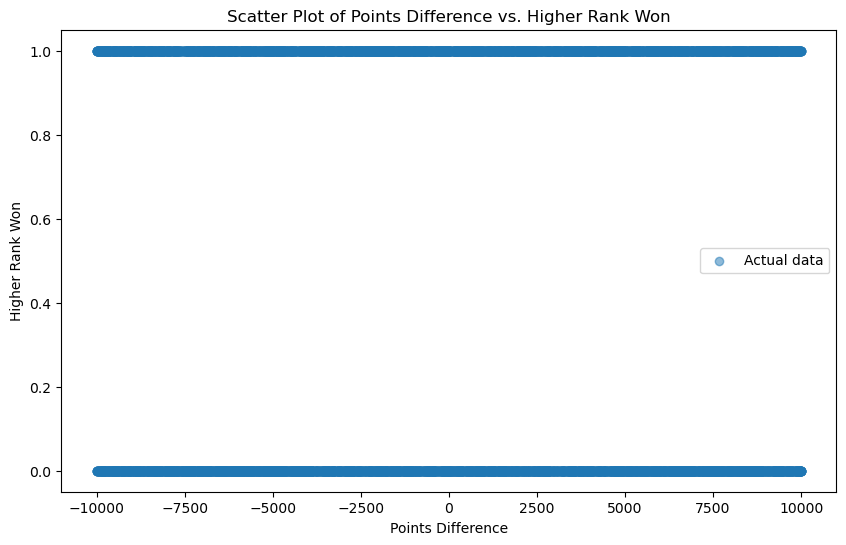

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Corrected data generation
data = {
    'points_diff': np.random.randint(-10001, 10001, 10001),  # Generating 10001 data points in the range -10001 to 10000
    'higher_rank_won': np.random.randint(0, 2, 10001)  # Generating 10001 binary outcomes
}

# Creating the DataFrame
df_odds_train = pd.DataFrame(data)

# Plotting the data
plt.figure(figsize=(10, 6))
plt.scatter(df_odds_train['points_diff'], df_odds_train['higher_rank_won'], alpha=0.5, label='Actual data')
plt.xlabel('Points Difference')
plt.ylabel('Higher Rank Won')
plt.title('Scatter Plot of Points Difference vs. Higher Rank Won')
plt.legend()
plt.show()

In [35]:
tennis_train_predictions_logr = logr.predict(df_odds_train[['points_diff']])
tennis_train_predictions_logr

tennis_train_prediction_prob_logr = logr.predict_proba(df_odds_train[['points_diff']])[:,1]
tennis_train_prediction_prob_logr

array([0.16830899, 0.0167246 , 0.94475021, ..., 0.50149593, 0.01089474,
       0.04066794])

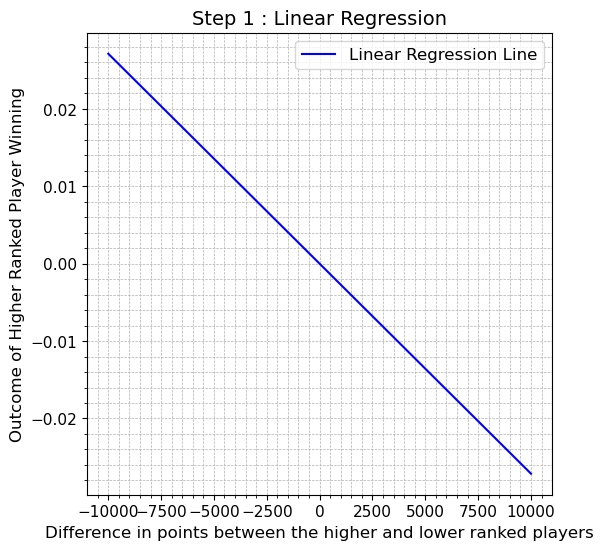

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression

# Corrected data generation
data = {
    'points_diff': np.random.randint(-10001, 10001, 10001),  # Generating 10001 data points in the range -10001 to 10001
    'higher_rank_won': np.random.randint(0, 2, 10001)  # Generating 10001 binary outcomes
}

# Creating the DataFrame
df_odds_train = pd.DataFrame(data)

# Fit a linear regression model
linear_model = LinearRegression(fit_intercept=False)
linear_model.fit(df_odds_train[['points_diff']], df_odds_train['higher_rank_won'])

# Predicting values
X_test_linear = np.linspace(df_odds_train['points_diff'].min(), df_odds_train['points_diff'].max(), 300).reshape(-1, 1)
y_pred_linear = linear_model.predict(X_test_linear)

# Plotting the linear regression line with reduced font and enhanced aesthetics
plt.figure(figsize=(6, 6))
plt.plot(X_test_linear, y_pred_linear, label='Linear Regression Line', color='blue')
plt.xlabel("Difference in points between the higher and lower ranked players", fontsize=12)
plt.title("Step 1 : Linear Regression", fontsize=14)
plt.ylabel("Outcome of Higher Ranked Player Winning", fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.minorticks_on()
plt.legend(fontsize=12)
plt.show()

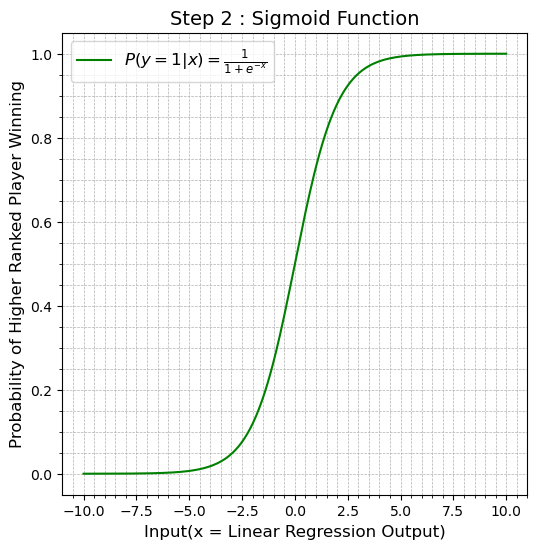

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Define the sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Generate data for the sigmoid curve
X = np.linspace(-10, 10, 300)
y = sigmoid(X)

# Plotting the sigmoid curve
plt.figure(figsize=(6, 6))
plt.plot(X, y, label=r'$P(y = 1|x) = \frac{1}{1 + e^{-x}}$', color='green')
plt.xlabel("Input(x = Linear Regression Output)", fontsize=12)
plt.ylabel("Probability of Higher Ranked Player Winning", fontsize=12)
plt.title("Step 2 : Sigmoid Function", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.minorticks_on()
plt.legend(fontsize=12, )
plt.show()


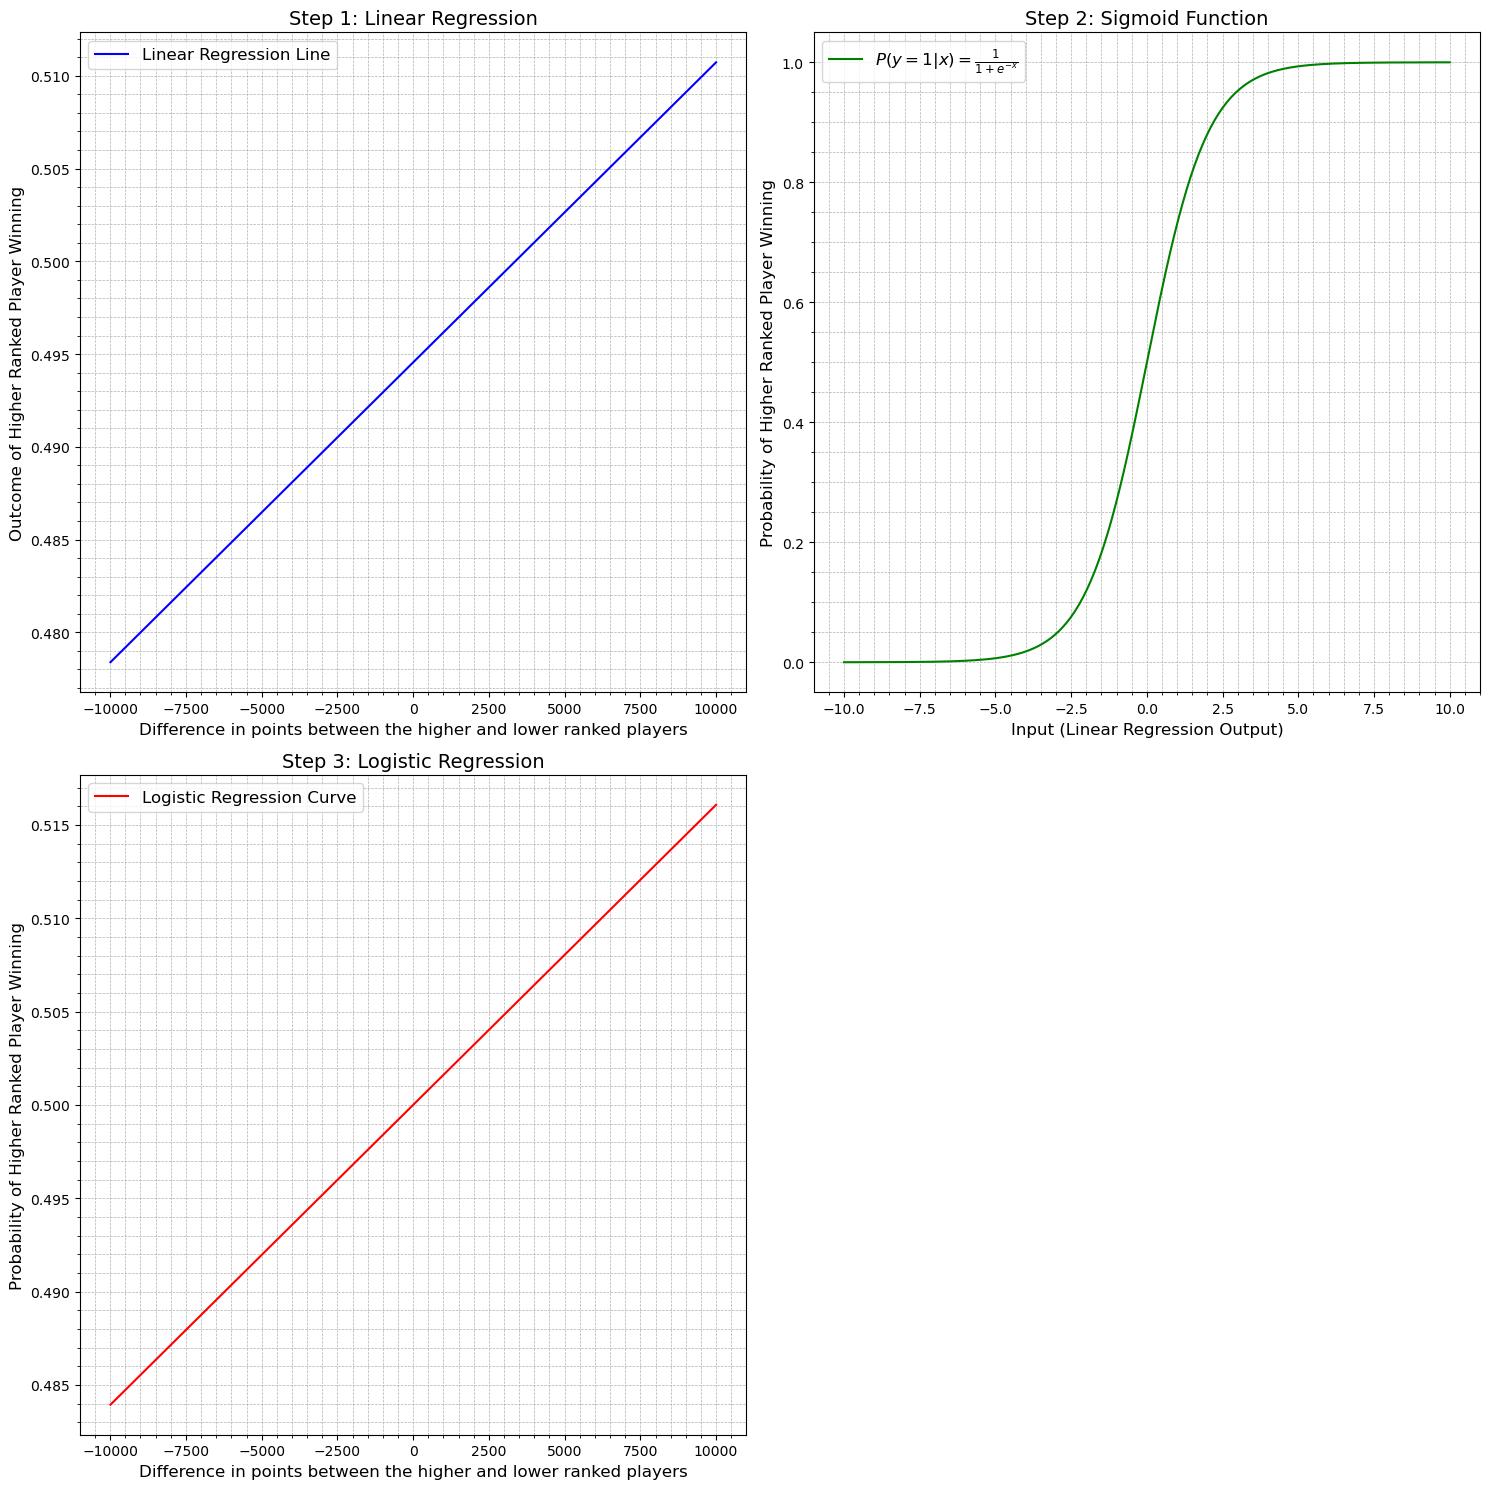

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression

# Define the sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Generate data for linear regression
np.random.seed(0)
points_diff = np.random.randint(-10001, 10001, 10001)
higher_rank_won = np.random.randint(0, 2, 10001)

# Create and fit the linear regression model
linear_model = LinearRegression()
linear_model.fit(points_diff.reshape(-1, 1), higher_rank_won)

# Generate test data for linear regression predictions
X_test_linear = np.linspace(points_diff.min(), points_diff.max(), 300).reshape(-1, 1)
y_pred_linear = linear_model.predict(X_test_linear)

# Generate data for the sigmoid curve
X_sigmoid = np.linspace(-10, 10, 300)
y_sigmoid = sigmoid(X_sigmoid)

# Plotting the combined graphs
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
(ax1, ax2), (ax3, ax4) = ax

# Remove the unused subplot
fig.delaxes(ax4)

# Plot 1: Linear regression line
ax1.plot(X_test_linear, y_pred_linear, label='Linear Regression Line', color='blue')
ax1.set_xlabel("Difference in points between the higher and lower ranked players", fontsize=12)
ax1.set_ylabel("Outcome of Higher Ranked Player Winning", fontsize=12)
ax1.set_title("Step 1: Linear Regression", fontsize=14)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
ax1.minorticks_on()
ax1.legend(fontsize=12)
ax1.tick_params(axis='both', which='major', labelsize=10)

# Plot 2: Sigmoid function with the output of linear regression as its input
ax2.plot(X_sigmoid, y_sigmoid, label=r'$P(y=1|x) = \frac{1}{1 + e^{-x}}$', color='green')
ax2.set_xlabel("Input (Linear Regression Output)", fontsize=12)
ax2.set_ylabel("Probability of Higher Ranked Player Winning", fontsize=12)
ax2.set_title("Step 2: Sigmoid Function", fontsize=14)
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
ax2.minorticks_on()
ax2.legend(fontsize=12)
ax2.tick_params(axis='both', which='major', labelsize=10)

# Fitting a logistic regression model
logistic_model = LogisticRegression(fit_intercept = False)
logistic_model.fit(points_diff.reshape(-1, 1), higher_rank_won)

# Predicting probabilities for logistic regression
X_test_logistic = np.linspace(points_diff.min(), points_diff.max(), 300).reshape(-1, 1)
y_prob_logistic = logistic_model.predict_proba(X_test_logistic)[:, 1]

# Plot 3: Logistic regression curve
ax3.plot(X_test_logistic, y_prob_logistic, label='Logistic Regression Curve', color='red')
ax3.set_xlabel("Difference in points between the higher and lower ranked players", fontsize=12)
ax3.set_ylabel("Probability of Higher Ranked Player Winning", fontsize=12)
ax3.set_title("Step 3: Logistic Regression", fontsize=14)
ax3.grid(True, which='both', linestyle='--', linewidth=0.5)
ax3.minorticks_on()
ax3.legend(fontsize=12)
ax3.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()


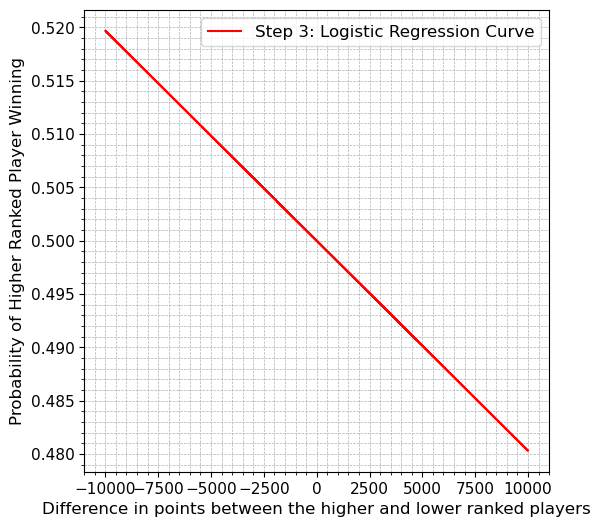

In [39]:
# Fitting a logistic regression model
logistic_model = LogisticRegression(fit_intercept = False)
logistic_model.fit(df_odds_train[['points_diff']], df_odds_train['higher_rank_won'])

# Predicting probabilities
diff = np.random.randint(-10001, 10001, 10001).reshape(-1, 1) 
y_prob_logistic = logistic_model.predict_proba(diff)[:, 1]

# Plotting the logistic regression curve with reduced font and enhanced aesthetics
plt.figure(figsize=(6, 6))
plt.plot(diff, y_prob_logistic, label='Step 3: Logistic Regression Curve', color='red')
plt.xlabel("Difference in points between the higher and lower ranked players", fontsize=12)
plt.ylabel("Probability of Higher Ranked Player Winning", fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.minorticks_on()
plt.legend(fontsize=12)
plt.show()

In [40]:
evaluate_predictions(df_odds_train["higher_rank_won"], tennis_train_predictions_logr, tennis_train_prediction_prob_logr)

{'accuracy': 0.5027497250274973,
 'calibration': 0.994246482863984,
 'log_loss': 1.3231378143704537}

### Metrics for Test Data

In [41]:
tennis_validation_predictions_logr = logr.predict(df_odds_validation[['points_diff']])
tennis_validation_predictions_logr

tennis_validation_prediction_prob_logr = logr.predict_proba(df_odds_validation[['points_diff']])[:,1]
tennis_validation_prediction_prob_logr

array([0.51886285, 0.52012672, 0.50069043, ..., 0.73263456, 0.72260072,
       0.61580855])

In [42]:
evaluate_predictions(df_odds_validation['higher_rank_won'], tennis_validation_predictions_logr,  tennis_validation_prediction_prob_logr)

{'accuracy': 0.61473197069032,
 'calibration': 1.0040545019575327,
 'log_loss': 0.6525057182212286}

In [43]:
df_odds_validation

,ATP,Date,higher_rank_won,higher_rank_points,lower_rank_points,points_diff,WRank,LRank,Best of,Winner,...,Surface_Grass,Surface_Hard,Round_1st Round,Round_2nd Round,Round_3rd Round,Round_4th Round,Round_Quarterfinals,Round_Round Robin,Round_Semifinals,Round_The Final
0,1,2019-01-01,0,974.0,810.0,164.0,63.0,49.0,3,Kudla D.,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2019-01-01,1,1050.0,875.0,175.0,40.0,57.0,3,Chardy J.,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,2019-01-01,0,206.0,200.0,6.0,240.0,234.0,3,Murray A.,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,2019-01-01,1,1125.0,810.0,315.0,35.0,62.0,3,Kyrgios N.,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,2019-01-01,0,367.0,200.0,167.0,239.0,146.0,3,Tsonga J.W.,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2588,66,2019-11-15,1,9585.0,4000.0,5585.0,1.0,6.0,3,Nadal R.,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2589,66,2019-11-15,0,5705.0,2945.0,2760.0,7.0,4.0,3,Zverev A.,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2590,66,2019-11-16,0,6190.0,4000.0,2190.0,6.0,3.0,3,Tsitsipas S.,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2591,66,2019-11-16,1,5025.0,2945.0,2080.0,5.0,7.0,3,Thiem D.,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [44]:
bookmakers = ['B365', 'PS']

## BCM Model

In [45]:
for bookmaker in bookmakers:
    df_odds_validation[f'{bookmaker}_prob_w'], df_odds_validation[f'{bookmaker}_prob_l'] = zip(*df_odds_validation.apply(lambda row: calculate_implied_probabilities(row[f'{bookmaker}W'], row[f'{bookmaker}L']), axis=1))

In [46]:
 df_odds_validation

,ATP,Date,higher_rank_won,higher_rank_points,lower_rank_points,points_diff,WRank,LRank,Best of,Winner,...,Round_3rd Round,Round_4th Round,Round_Quarterfinals,Round_Round Robin,Round_Semifinals,Round_The Final,B365_prob_w,B365_prob_l,PS_prob_w,PS_prob_l
0,1,2019-01-01,0,974.0,810.0,164.0,63.0,49.0,3,Kudla D.,...,0.0,0.0,0.0,0.0,0.0,0.0,0.354680,0.645320,0.347319,0.652681
1,1,2019-01-01,1,1050.0,875.0,175.0,40.0,57.0,3,Chardy J.,...,0.0,0.0,0.0,0.0,0.0,0.0,0.441489,0.558511,0.435443,0.564557
2,1,2019-01-01,0,206.0,200.0,6.0,240.0,234.0,3,Murray A.,...,0.0,0.0,0.0,0.0,0.0,0.0,0.732218,0.267782,0.704497,0.295503
3,1,2019-01-01,1,1125.0,810.0,315.0,35.0,62.0,3,Kyrgios N.,...,0.0,0.0,0.0,0.0,0.0,0.0,0.662651,0.337349,0.661290,0.338710
4,1,2019-01-01,0,367.0,200.0,167.0,239.0,146.0,3,Tsonga J.W.,...,0.0,0.0,0.0,0.0,0.0,0.0,0.410995,0.589005,0.428212,0.571788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2588,66,2019-11-15,1,9585.0,4000.0,5585.0,1.0,6.0,3,Nadal R.,...,0.0,0.0,0.0,1.0,0.0,0.0,0.656325,0.343675,0.701075,0.298925
2589,66,2019-11-15,0,5705.0,2945.0,2760.0,7.0,4.0,3,Zverev A.,...,0.0,0.0,0.0,1.0,0.0,0.0,0.500000,0.500000,0.455471,0.544529
2590,66,2019-11-16,0,6190.0,4000.0,2190.0,6.0,3.0,3,Tsitsipas S.,...,0.0,0.0,0.0,0.0,1.0,0.0,0.270833,0.729167,0.261811,0.738189
2591,66,2019-11-16,1,5025.0,2945.0,2080.0,5.0,7.0,3,Thiem D.,...,0.0,0.0,0.0,0.0,1.0,0.0,0.526316,0.473684,0.532995,0.467005


In [47]:
def logit(p, eps=1e-6):
    p = np.clip(p, eps, 1 - eps)
    return np.log(p / (1 - p))

def inverse_logit(y):
    if pd.isna(y):
        return np.nan
    return np.exp(y) / (1 + np.exp(y))

In [48]:
for bookmaker in bookmakers :
    df_odds_validation[f'{bookmaker}_logit_prob_w'] = df_odds_validation[f'{bookmaker}_prob_w'].apply(logit)

df_odds_validation['consensus_logit_prob_w'] = df_odds_validation[[f'{bookmaker}_logit_prob_w' for bookmaker in bookmakers]].mean(axis=1, skipna=True)

df_odds_validation['consensus_prob_w'] = df_odds_validation['consensus_logit_prob_w'].apply(inverse_logit)

In [49]:
df_odds_validation

,ATP,Date,higher_rank_won,higher_rank_points,lower_rank_points,points_diff,WRank,LRank,Best of,Winner,...,Round_Semifinals,Round_The Final,B365_prob_w,B365_prob_l,PS_prob_w,PS_prob_l,B365_logit_prob_w,PS_logit_prob_w,consensus_logit_prob_w,consensus_prob_w
0,1,2019-01-01,0,974.0,810.0,164.0,63.0,49.0,3,Kudla D.,...,0.0,0.0,0.354680,0.645320,0.347319,0.652681,-0.598531,-0.630843,-0.614687,0.350991
1,1,2019-01-01,1,1050.0,875.0,175.0,40.0,57.0,3,Chardy J.,...,0.0,0.0,0.441489,0.558511,0.435443,0.564557,-0.235120,-0.259677,-0.247399,0.438464
2,1,2019-01-01,0,206.0,200.0,6.0,240.0,234.0,3,Murray A.,...,0.0,0.0,0.732218,0.267782,0.704497,0.295503,1.005903,0.868804,0.937353,0.718565
3,1,2019-01-01,1,1125.0,810.0,315.0,35.0,62.0,3,Kyrgios N.,...,0.0,0.0,0.662651,0.337349,0.661290,0.338710,0.675129,0.669050,0.672089,0.661971
4,1,2019-01-01,0,367.0,200.0,167.0,239.0,146.0,3,Tsonga J.W.,...,0.0,0.0,0.410995,0.589005,0.428212,0.571788,-0.359855,-0.289152,-0.324503,0.419579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2588,66,2019-11-15,1,9585.0,4000.0,5585.0,1.0,6.0,3,Nadal R.,...,0.0,0.0,0.656325,0.343675,0.701075,0.298925,0.646958,0.852423,0.749691,0.679111
2589,66,2019-11-15,0,5705.0,2945.0,2760.0,7.0,4.0,3,Zverev A.,...,0.0,0.0,0.500000,0.500000,0.455471,0.544529,0.000000,-0.178590,-0.089295,0.477691
2590,66,2019-11-16,0,6190.0,4000.0,2190.0,6.0,3.0,3,Tsitsipas S.,...,1.0,0.0,0.270833,0.729167,0.261811,0.738189,-0.990399,-1.036577,-1.013488,0.266298
2591,66,2019-11-16,1,5025.0,2945.0,2080.0,5.0,7.0,3,Thiem D.,...,1.0,0.0,0.526316,0.473684,0.532995,0.467005,0.105361,0.132172,0.118766,0.529657


In [50]:
predictions, consensus_probabilities = [], []


for i, tennis_match_row in df_odds_validation.iterrows():
    consensus_prob_w1 = tennis_match_row['consensus_prob_w']
    if int(tennis_match_row['higher_rank_won']) == 1:
        prediction = int(consensus_prob_w1 > 0.5)
        probability = consensus_prob_w1
    else:
        prediction = int((1 - consensus_prob_w1) > 0.5)
        probability = 1 - consensus_prob_w1
    predictions.append(prediction)
    consensus_probabilities.append(probability)

df_odds_validation['predictions'], df_odds_validation['consensus_probabilities'] = predictions, consensus_probabilities

In [51]:
evaluate_predictions(df_odds_validation['higher_rank_won'], df_odds_validation['predictions'], df_odds_validation['consensus_probabilities'] )

{'accuracy': 0.6741226378711916,
 'calibration': 1.02319495412043,
 'log_loss': 0.594547215938251}

## Investigating Extensions

### Extension 1

1. Created a function, `precompute_top_players`, that identifies the top `n` players for each year based on their rankings.
2. Identified the top 50 and top 100 players for each year.
3. Created a new column, `Top50`, to indicate if both the winner and the loser of a match were among the top 50 players in that year.
4. Created a new column, `Top100`, to indicate if both the winner and the loser of a match were among the top 100 players in that year.
5. Extracted matches from 2019 that involved top 50 and top 100 players.


In [52]:
all_years_df = preprocess_dataset(all_years_df)

In [53]:
all_years_df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40390 entries, 0 to 40389
Data columns (total 323 columns):
 #    Column                                                   Dtype         
---   ------                                                   -----         
 0    ATP                                                      int64         
 1    Date                                                     datetime64[ns]
 2    higher_rank_won                                          int64         
 3    higher_rank_points                                       float64       
 4    lower_rank_points                                        float64       
 5    points_diff                                              float64       
 6    WRank                                                    float64       
 7    LRank                                                    float64       
 8    Best of                                                  int64         
 9    Winner                    

In [54]:
def precompute_top_players(data, top_n):
    # Group data by year, then find top n players based on 'WRank' and 'LRank' for winners and losers.
    top_players_by_year = {}
    for year, group in data.groupby(data['Date'].dt.year):
        top_winners = set(group.nsmallest(top_n, 'WRank')['Winner'].unique())
        top_losers = set(group.nsmallest(top_n, 'LRank')['Loser'].unique())
        top_players_by_year[year] = top_winners.union(top_losers)
    return top_players_by_year

In [55]:
top_50_players = precompute_top_players(all_years_df, 50)
top_100_players = precompute_top_players(all_years_df, 100)

In [56]:
top_50_players

{2005: {'Coria G.',
  'Federer R.',
  'Gaudio G.',
  'Henman T.',
  'Hewitt L.',
  'Moya C.',
  'Nadal R.',
  'Roddick A.',
  'Safin M.'},
 2006: {'Davydenko N.',
  'Federer R.',
  'Hewitt L.',
  'Ljubicic I.',
  'Nadal R.',
  'Nalbandian D.',
  'Roddick A.'},
 2007: {'Davydenko N.',
  'Djokovic N.',
  'Federer R.',
  'Ljubicic I.',
  'Nadal R.',
  'Roddick A.'},
 2008: {'Davydenko N.', 'Djokovic N.', 'Federer R.', 'Ferrer D.', 'Nadal R.'},
 2009: {'Djokovic N.', 'Federer R.', 'Federer R. ', 'Murray A.', 'Nadal R.'},
 2010: {'Djokovic N.', 'Federer R.', 'Murray A.', 'Nadal R.'},
 2011: {'Djokovic N.', 'Federer R.', 'Murray A.', 'Nadal R.', 'Soderling R.'},
 2012: {'Djokovic N.',
  'Federer R.',
  'Ferrer D.',
  'Murray A.',
  'Nadal R.',
  'Tsonga J.W.'},
 2013: {'Djokovic N.', 'Federer R.', 'Ferrer D.', 'Murray A.', 'Nadal R.'},
 2014: {'Del Potro J.M.',
  'Djokovic N.',
  'Federer R.',
  'Ferrer D.',
  'Murray A.',
  'Nadal R.',
  'Wawrinka S.'},
 2015: {'Berdych T.',
  'Djokovic N.'

In [57]:
all_years_df['Top50'] = all_years_df.apply(lambda row: row['Winner'] in top_50_players[row['Date'].year] and row['Loser'] in top_50_players[row['Date'].year], axis=1)
all_years_df['Top100'] = all_years_df.apply(lambda row: row['Winner'] in top_100_players[row['Date'].year] and row['Loser'] in top_100_players[row['Date'].year], axis=1)

In [58]:
df_odds_validation_top_50 = all_years_df[(all_years_df['Top50'] == True) & (all_years_df['Date'].dt.year == 2019)]
df_odds_validation_top_100 = all_years_df[(all_years_df['Top100'] == True) & (all_years_df['Date'].dt.year == 2019)]

In [59]:
df_odds_validation_top_50

,ATP,Date,higher_rank_won,higher_rank_points,lower_rank_points,points_diff,WRank,LRank,Best of,Winner,...,Round_1st Round,Round_2nd Round,Round_3rd Round,Round_4th Round,Round_Quarterfinals,Round_Round Robin,Round_Semifinals,Round_The Final,Top50,Top100
38038,6,2019-01-21,1,9135.0,1865.0,7270.0,1.0,19.0,5,Djokovic N.,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,True,True
38045,6,2019-01-27,1,9135.0,7480.0,1655.0,1.0,2.0,5,Djokovic N.,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,True,True
38483,19,2019-03-16,0,8365.0,4600.0,3765.0,4.0,2.0,3,Federer R.,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,True,True
38484,19,2019-03-17,0,4600.0,3800.0,800.0,8.0,4.0,3,Thiem D.,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,True,True
38572,20,2019-03-27,1,4600.0,2230.0,2370.0,5.0,15.0,3,Federer R.,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,True,True
38687,23,2019-04-19,0,11070.0,2295.0,8775.0,14.0,1.0,3,Medvedev D.,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,True,True
38738,24,2019-04-27,0,8085.0,4675.0,3410.0,5.0,2.0,3,Thiem D.,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,True,True
38739,24,2019-04-28,1,4675.0,2505.0,2170.0,5.0,14.0,3,Thiem D.,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,True,True
38870,28,2019-05-10,0,5590.0,5085.0,505.0,5.0,3.0,3,Thiem D.,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,True,True
38873,28,2019-05-11,1,11160.0,5085.0,6075.0,1.0,5.0,3,Djokovic N.,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,True,True


#### BCM Model for top 50

In [60]:
for bookmaker in bookmakers:
    df_odds_validation_top_50[f'{bookmaker}_prob_w'], df_odds_validation_top_50[f'{bookmaker}_prob_l'] = zip(*df_odds_validation_top_50.apply(lambda row: calculate_implied_probabilities(row[f'{bookmaker}W'], row[f'{bookmaker}L']), axis=1))

In [61]:
for bookmaker in bookmakers :
    df_odds_validation_top_50[f'{bookmaker}_logit_prob_w'] = df_odds_validation_top_50[f'{bookmaker}_prob_w'].apply(logit)

df_odds_validation_top_50['consensus_logit_prob_w'] = df_odds_validation_top_50[[f'{bookmaker}_logit_prob_w' for bookmaker in bookmakers]].mean(axis=1, skipna=True)

df_odds_validation_top_50['consensus_prob_w'] = df_odds_validation_top_50['consensus_logit_prob_w'].apply(inverse_logit)

In [62]:
df_odds_validation_top_50

,ATP,Date,higher_rank_won,higher_rank_points,lower_rank_points,points_diff,WRank,LRank,Best of,Winner,...,Top50,Top100,B365_prob_w,B365_prob_l,PS_prob_w,PS_prob_l,B365_logit_prob_w,PS_logit_prob_w,consensus_logit_prob_w,consensus_prob_w
38038,6,2019-01-21,1,9135.0,1865.0,7270.0,1.0,19.0,5,Djokovic N.,...,True,True,0.854139,0.145861,0.855164,0.144836,1.767442,1.775689,1.771566,0.854652
38045,6,2019-01-27,1,9135.0,7480.0,1655.0,1.0,2.0,5,Djokovic N.,...,True,True,0.552699,0.447301,0.554156,0.445844,0.211583,0.217478,0.214530,0.553428
38483,19,2019-03-16,0,8365.0,4600.0,3765.0,4.0,2.0,3,Federer R.,...,True,True,0.656325,0.343675,0.666667,0.333333,0.646958,0.693147,0.670052,0.661515
38484,19,2019-03-17,0,4600.0,3800.0,800.0,8.0,4.0,3,Thiem D.,...,True,True,0.238095,0.761905,0.223801,0.776199,-1.163151,-1.243651,-1.203401,0.230871
38572,20,2019-03-27,1,4600.0,2230.0,2370.0,5.0,15.0,3,Federer R.,...,True,True,0.729167,0.270833,0.727273,0.272727,0.990399,0.980829,0.985614,0.728221
38687,23,2019-04-19,0,11070.0,2295.0,8775.0,14.0,1.0,3,Medvedev D.,...,True,True,0.219820,0.780180,0.210526,0.789474,-1.266717,-1.321756,-1.294236,0.215137
38738,24,2019-04-27,0,8085.0,4675.0,3410.0,5.0,2.0,3,Thiem D.,...,True,True,0.298246,0.701754,0.289916,0.710084,-0.855666,-0.895792,-0.875729,0.294064
38739,24,2019-04-28,1,4675.0,2505.0,2170.0,5.0,14.0,3,Thiem D.,...,True,True,0.745527,0.254473,0.743191,0.256809,1.074896,1.062619,1.068757,0.744361
38870,28,2019-05-10,0,5590.0,5085.0,505.0,5.0,3.0,3,Thiem D.,...,True,True,0.656325,0.343675,0.667421,0.332579,0.646958,0.696543,0.671750,0.661895
38873,28,2019-05-11,1,11160.0,5085.0,6075.0,1.0,5.0,3,Djokovic N.,...,True,True,0.526316,0.473684,0.539241,0.460759,0.105361,0.157285,0.131323,0.532784


In [63]:
predictions, consensus_probabilities = [], []


for i, tennis_match_row in df_odds_validation_top_50.iterrows():
    consensus_prob_w1 = tennis_match_row['consensus_prob_w']
    if int(tennis_match_row['higher_rank_won']) == 1:
        prediction = int(consensus_prob_w1 > 0.5)
        probability = consensus_prob_w1
    else:
        prediction = int((1 - consensus_prob_w1) > 0.5)
        probability = 1 - consensus_prob_w1
    predictions.append(prediction)
    consensus_probabilities.append(probability)

df_odds_validation_top_50['predictions'], df_odds_validation_top_50['consensus_probabilities'] = predictions, consensus_probabilities

In [64]:
df_odds_validation_top_50

,ATP,Date,higher_rank_won,higher_rank_points,lower_rank_points,points_diff,WRank,LRank,Best of,Winner,...,B365_prob_w,B365_prob_l,PS_prob_w,PS_prob_l,B365_logit_prob_w,PS_logit_prob_w,consensus_logit_prob_w,consensus_prob_w,predictions,consensus_probabilities
38038,6,2019-01-21,1,9135.0,1865.0,7270.0,1.0,19.0,5,Djokovic N.,...,0.854139,0.145861,0.855164,0.144836,1.767442,1.775689,1.771566,0.854652,1,0.854652
38045,6,2019-01-27,1,9135.0,7480.0,1655.0,1.0,2.0,5,Djokovic N.,...,0.552699,0.447301,0.554156,0.445844,0.211583,0.217478,0.214530,0.553428,1,0.553428
38483,19,2019-03-16,0,8365.0,4600.0,3765.0,4.0,2.0,3,Federer R.,...,0.656325,0.343675,0.666667,0.333333,0.646958,0.693147,0.670052,0.661515,0,0.338485
38484,19,2019-03-17,0,4600.0,3800.0,800.0,8.0,4.0,3,Thiem D.,...,0.238095,0.761905,0.223801,0.776199,-1.163151,-1.243651,-1.203401,0.230871,1,0.769129
38572,20,2019-03-27,1,4600.0,2230.0,2370.0,5.0,15.0,3,Federer R.,...,0.729167,0.270833,0.727273,0.272727,0.990399,0.980829,0.985614,0.728221,1,0.728221
38687,23,2019-04-19,0,11070.0,2295.0,8775.0,14.0,1.0,3,Medvedev D.,...,0.219820,0.780180,0.210526,0.789474,-1.266717,-1.321756,-1.294236,0.215137,1,0.784863
38738,24,2019-04-27,0,8085.0,4675.0,3410.0,5.0,2.0,3,Thiem D.,...,0.298246,0.701754,0.289916,0.710084,-0.855666,-0.895792,-0.875729,0.294064,1,0.705936
38739,24,2019-04-28,1,4675.0,2505.0,2170.0,5.0,14.0,3,Thiem D.,...,0.745527,0.254473,0.743191,0.256809,1.074896,1.062619,1.068757,0.744361,1,0.744361
38870,28,2019-05-10,0,5590.0,5085.0,505.0,5.0,3.0,3,Thiem D.,...,0.656325,0.343675,0.667421,0.332579,0.646958,0.696543,0.671750,0.661895,0,0.338105
38873,28,2019-05-11,1,11160.0,5085.0,6075.0,1.0,5.0,3,Djokovic N.,...,0.526316,0.473684,0.539241,0.460759,0.105361,0.157285,0.131323,0.532784,1,0.532784


In [65]:
evaluate_predictions(df_odds_validation_top_50['higher_rank_won'], df_odds_validation_top_50['predictions'], df_odds_validation_top_50['consensus_probabilities'] )

{'accuracy': 0.6538461538461539,
 'calibration': 1.2180989856915425,
 'log_loss': 0.6353752690773093}

#### BCM Model for top 100

In [66]:
for bookmaker in bookmakers:
    df_odds_validation_top_100[f'{bookmaker}_prob_w'], df_odds_validation_top_100[f'{bookmaker}_prob_l'] = zip(*df_odds_validation_top_100.apply(lambda row: calculate_implied_probabilities(row[f'{bookmaker}W'], row[f'{bookmaker}L']), axis=1))

In [67]:
for bookmaker in bookmakers :
    df_odds_validation_top_100[f'{bookmaker}_logit_prob_w'] = df_odds_validation_top_100[f'{bookmaker}_prob_w'].apply(logit)

df_odds_validation_top_100['consensus_logit_prob_w'] = df_odds_validation_top_100[[f'{bookmaker}_logit_prob_w' for bookmaker in bookmakers]].mean(axis=1, skipna=True)

df_odds_validation_top_100['consensus_prob_w'] = df_odds_validation_top_100['consensus_logit_prob_w'].apply(inverse_logit)

In [68]:
predictions, consensus_probabilities = [], []


for i, tennis_match_row in df_odds_validation_top_100.iterrows():
    consensus_prob_w1 = tennis_match_row['consensus_prob_w']
    if int(tennis_match_row['higher_rank_won']) == 1:
        prediction = int(consensus_prob_w1 > 0.5)
        probability = consensus_prob_w1
    else:
        prediction = int((1 - consensus_prob_w1) > 0.5)
        probability = 1 - consensus_prob_w1
    predictions.append(prediction)
    consensus_probabilities.append(probability)

df_odds_validation_top_100['predictions'], df_odds_validation_top_100['consensus_probabilities'] = predictions, consensus_probabilities

In [69]:
evaluate_predictions(df_odds_validation_top_100['higher_rank_won'], df_odds_validation_top_100['predictions'], df_odds_validation_top_100['consensus_probabilities'] )

{'accuracy': 0.6491228070175439,
 'calibration': 1.2157398245759343,
 'log_loss': 0.6619411284626758}

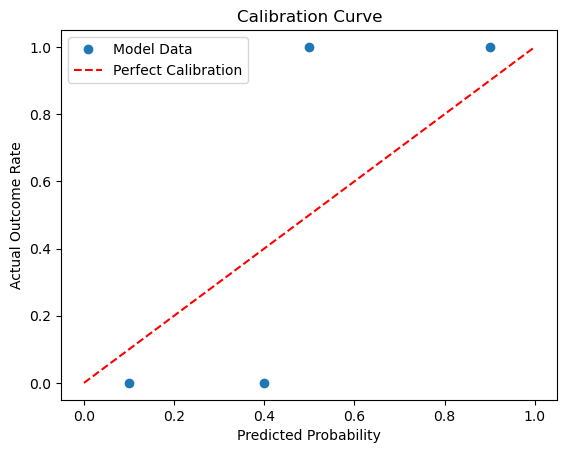

In [70]:
import matplotlib.pyplot as plt
import pandas as pd

# Example DataFrame
data = pd.DataFrame({
    'predicted_probability': [0.1, 0.4, 0.5, 0.9],
    'actual_outcome': [0, 0, 1, 1]
})

# Binning data
data['bin'] = pd.cut(data['predicted_probability'], bins=10)

# Calculating means
plot_data = data.groupby('bin').agg(
    avg_pred_prob=('predicted_probability', 'mean'),
    actual_rate=('actual_outcome', 'mean')
)

# Plotting
plt.plot(plot_data['avg_pred_prob'], plot_data['actual_rate'], marker='o', linestyle='', label='Model Data')
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Calibration')
plt.xlabel('Predicted Probability')
plt.ylabel('Actual Outcome Rate')
plt.title('Calibration Curve')
plt.legend()
plt.show()


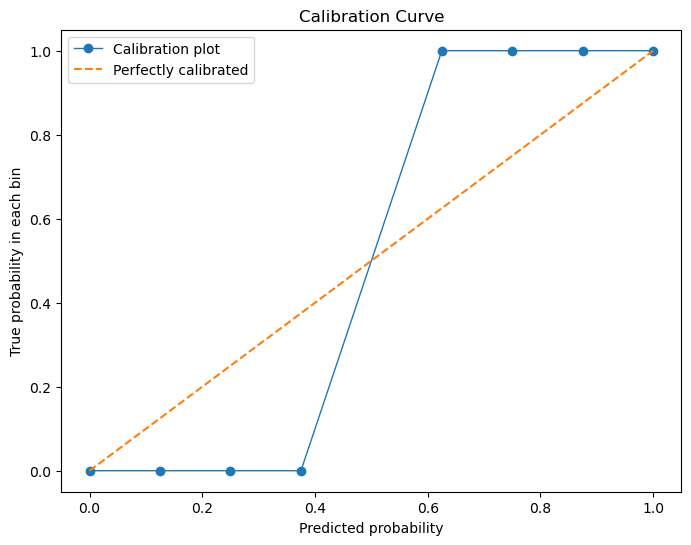

In [71]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# Example data: y_true are actual classes, y_prob are predicted probabilities
y_true = [0, 1, 1, 0, 1, 1, 0, 1, 1, 0]
y_prob = [0.1, 0.8, 0.7, 0.2, 0.6, 0.9, 0.3, 0.8, 0.9, 0.4]

# Generate the calibration data
prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10, normalize=True)

# Plotting the calibration curve
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label='Calibration plot')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Predicted probability')
plt.ylabel('True probability in each bin')
plt.legend()
plt.title('Calibration Curve')
plt.show()


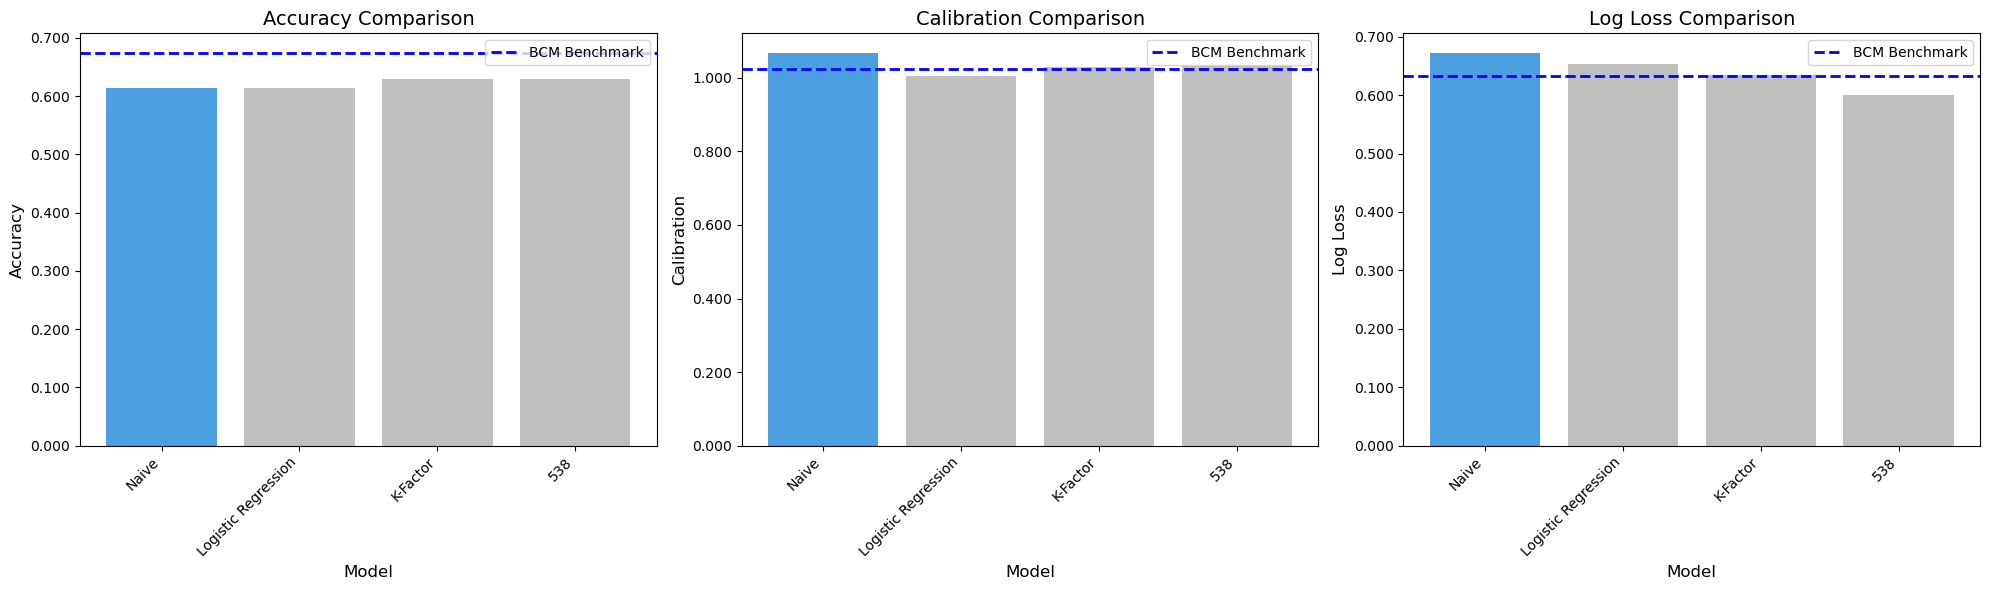

In [72]:
import pandas as pd
import matplotlib.pyplot as plt

# Data preparation
data = {
    'Model': ['Naive', 'Logistic Regression', 'K-Factor', '538', 'BCM'],
    'Accuracy': [0.6139606633243347, 0.61473197069032, 0.6298, 0.6301, 0.6741226378711916],
    'Calibration': [1.0674561520207362, 1.004, 1.0281, 1.032, 1.0231948932893524],
    'Log Loss': [0.6721, 0.6525, 0.6340, 0.60, 0.633]
}

df = pd.DataFrame(data)

# Exclude BCM model for bar charts
df_bars = df[df['Model'] != 'BCM']

# BCM Model benchmark values (not normalized)
bcm_accuracy = 0.6741226378711916
bcm_calibration = 1.0231948932893524
bcm_log_loss = 0.633

# Create a figure and a set of subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 6), constrained_layout=True)

# Bar color for emphasis on Naive model
colors = ['#0078D7' if model == 'Naive' else '#A6A6A6' for model in df_bars['Model']]  # Blue for Naive, grey for others

# Format y-axis labels to show three decimal places
from matplotlib.ticker import FormatStrFormatter

for ax in axs:
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

# Accuracy Bar Plot
axs[0].bar(df_bars['Model'], df_bars['Accuracy'], color=colors, alpha=0.7)
axs[0].axhline(y=bcm_accuracy, color='blue', linestyle='--', linewidth=2, label='BCM Benchmark')
axs[0].set_xlabel('Model', fontsize=12)
axs[0].set_ylabel('Accuracy', fontsize=12)
axs[0].set_title('Accuracy Comparison', fontsize=14)
axs[0].set_xticklabels(df_bars['Model'], rotation=45, ha='right')
axs[0].legend()

# Calibration Bar Plot
axs[1].bar(df_bars['Model'], df_bars['Calibration'], color=colors, alpha=0.7)
axs[1].axhline(y=bcm_calibration, color='blue', linestyle='--', linewidth=2, label='BCM Benchmark')
axs[1].set_xlabel('Model', fontsize=12)
axs[1].set_ylabel('Calibration', fontsize=12)
axs[1].set_title('Calibration Comparison', fontsize=14)
axs[1].set_xticklabels(df_bars['Model'], rotation=45, ha='right')
axs[1].legend()

# Log Loss Bar Plot
axs[2].bar(df_bars['Model'], df_bars['Log Loss'], color=colors, alpha=0.7)
axs[2].axhline(y=bcm_log_loss, color='blue', linestyle='--', linewidth=2, label='BCM Benchmark')
axs[2].set_xlabel('Model', fontsize=12)
axs[2].set_ylabel('Log Loss', fontsize=12)
axs[2].set_title('Log Loss Comparison', fontsize=14)
axs[2].set_xticklabels(df_bars['Model'], rotation=45, ha='right')
axs[2].legend()

# Show the plot
plt.tight_layout()
plt.show()
